[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

In [17]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import optuna
import os
import cv2
from tqdm import tqdm
from glob import glob
import random
from pathlib import Path

/home/beast/anaconda3/envs/eden_pytorch_transfer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Function for plotting images.
def plot_sample(X):
    # Plotting 9 sample images
    num_rows = 3
    num_cols = 3
    plt.figure(figsize=(8, 8))
    
    for ix in range(num_rows*num_cols):
        plt.subplot(num_cols, num_rows, ix+1)
        plt.imshow(random.choice(X))
        plt.axis("off")
    
    plt.show()

def read_data(path_list, im_size=(128,128)):
    
    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file) 
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) #Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y #np.array(y)

def get_dataloaders(x, y):
    """
    It returns the DataLoaders necessary for training and validating.
    """
    data_transforms = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0)]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
    train_dataset = TensorDataset(torch.permute(torch.Tensor(x_train), (0, 3, 1, 2)), 
                                  torch.Tensor(y_train)) # create your datset
    train_dataset.transform = data_transforms
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE) # create your dataloader
    valid_dataset = TensorDataset(torch.permute(torch.Tensor(x_test), (0, 3, 1, 2)), torch.Tensor(y_test)) # create your datset
    valid_dataset.transform = data_transforms
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE) # create your dataloader

    return train_loader, valid_loader

In [35]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
NUM_CLASSES = 4
NUM_EPOCHS = 50
BATCH_SIZE = 16
INPUT_SIZE = 128
IM_SIZE = (128, 128)
NUM_TRIALS = 100

In [20]:
PATH_LIST = [
    "Cotton-100619-Healthy-zz-V1-20210225102300",
    "Black nightsade-220519-Weed-zz-V1-20210225102034",
    "Tomato-240519-Healthy-zz-V1-202102251037402",
    "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]

In [21]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(
        Path(Path.cwd()).parents[0].joinpath("eden_library_datasets").joinpath(path)
    )
    i += 1
x, y = read_data(PATH_LIST, IM_SIZE)

 62%|██████▏   | 77/124 [00:11<00:05,  8.57it/s]

Not a picture


 64%|██████▍   | 130/202 [00:29<00:18,  3.92it/s]

Not a picture


 69%|██████▉   | 84/121 [00:12<00:04,  8.59it/s]

Not a picture


100%|██████████| 121/121 [00:18<00:00,  6.60it/s]


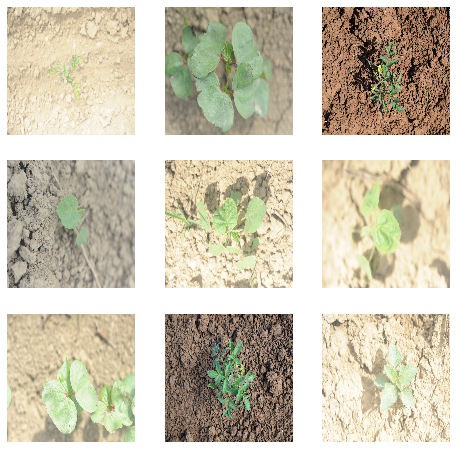

In [22]:
plot_sample(x)

In [23]:
train_loader, valid_loader = get_dataloaders(x, y)

In [24]:
class ConvNet(nn.Module):
    def __init__(self, trial):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        dropout_rate_1 = trial.suggest_float("dropout_rate_1", 0, 0.5, step=0.1)
        self.drop_1 = nn.Dropout(p=dropout_rate_1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        dropout_rate_2 = trial.suggest_float("dropout_rate_2", 0, 0.5, step=0.1)
        self.drop_2 = nn.Dropout(p=dropout_rate_2)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        dropout_rate_3 = trial.suggest_float("dropout_rate_3", 0, 0.5, step=0.1)
        self.drop_3 = nn.Dropout(p=dropout_rate_3)
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 32, 128, 32)
        self.fc1 = nn.Linear(128 * 16 * 16, fc2_input_dim)
        dropout_rate_4 = trial.suggest_float("dropout_rate2", 0, 0.5, step=0.1)
        self.drop_4 = nn.Dropout(p=dropout_rate_4)
        self.fc2 = nn.Linear(fc2_input_dim, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.drop_1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = self.drop_2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2))
        x = self.drop_3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_4(x)
        x = self.fc2(x)
        return x

In [36]:
def objective(trial):

    # Generate the model.
    model = ConvNet(trial).to(DEVICE)

    # Generate the optimizers.
    # try Adam, AdaDelta and Adagrad
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["Adam", "Adadelta", "Adagrad"]
    )
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # Training of the model.
    for epoch in range(NUM_EPOCHS):
        model.train()

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                labels_norm = labels.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels_norm.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [37]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=NUM_TRIALS)

[I 2022-06-16 13:20:56,416] A new study created in memory with name: no-name-1528260c-d726-4fd1-bbb3-e81a92d6d12f
[I 2022-06-16 13:21:02,490] Trial 0 finished with value: 0.5337423312883436 and parameters: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.30000000000000004, 'dropout_rate_3': 0.2, 'fc2_input_dim': 32, 'dropout_rate2': 0.2, 'optimizer': 'Adam', 'lr': 0.0023547824182933727}. Best is trial 0 with value: 0.5337423312883436.
[I 2022-06-16 13:21:08,769] Trial 1 finished with value: 0.32515337423312884 and parameters: {'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'dropout_rate_3': 0.0, 'fc2_input_dim': 32, 'dropout_rate2': 0.2, 'optimizer': 'Adadelta', 'lr': 1.642636552632549e-05}. Best is trial 0 with value: 0.5337423312883436.
[I 2022-06-16 13:21:14,740] Trial 2 finished with value: 0.5398773006134969 and parameters: {'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'dropout_rate_3': 0.5, 'fc2_input_dim': 32, 'dropout_rate2': 0.0, 'optimizer': 'Adam', 'lr': 0.011375394397880201}. Be

In [40]:
best_trial = study.best_trial

In [41]:
print(f"Accuracy: {best_trial.value}")
print(f"Best hyperparameters: {best_trial.params}")

Accuracy: 0.8834355828220859
Best hyperparameters: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.30000000000000004, 'dropout_rate_3': 0.5, 'fc2_input_dim': 32, 'dropout_rate2': 0.2, 'optimizer': 'Adam', 'lr': 0.0037981920114391983}


In [42]:
optuna.visualization.plot_contour(study, params=["optimizer", "lr"])

In [43]:
optuna.visualization.plot_param_importances(study)